In [1]:
# the RB coefficients can have very high frequency oscillations.
# I suspect this is due to time alignment so will investigate this here.

In [2]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})

In [3]:
import numpy as np
import os
import datetime

In [4]:
import rompy as rp

In [5]:
import phenom

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [7]:
from scrinet.interfaces import lalutils

In [8]:
import scrinet.workflow.generators

In [9]:
from scrinet.greedy import greedyrb

In [10]:
import lalsimulation as lalsim

# peak function

In [35]:
import scipy.stats

In [94]:
xtest = np.linspace(-20, 20, 10000)
ytest = scipy.stats.norm(5, 1).pdf(xtest)

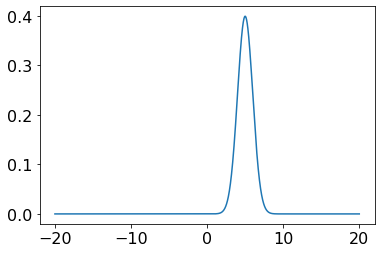

In [95]:
plt.figure()
plt.plot(xtest, ytest)

In [134]:
tshift = lalutils.peak_align_shift(xtest, ytest)

In [135]:
tshift

4.999999961496111

In [136]:
ytest_new = lalutils.peak_align_interp(xtest, ytest, tshift)

(-10, 10)

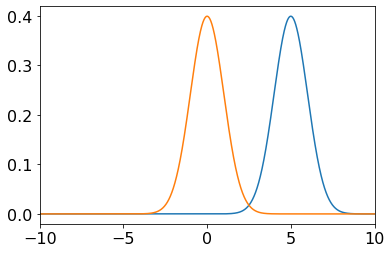

In [137]:
plt.figure()
plt.plot(xtest, ytest)
plt.plot(xtest, ytest_new)
plt.xlim(-10,10)

In [138]:
xtest[ytest.argmax()]

4.998499849984999

In [139]:
xtest[ytest_new.argmax()]

0.002000200020003007

# streamlined function

In [11]:
def plot_coeff(coords, alphas, index, join=False):
    plt.figure()
    if join:
        plt.plot(coords, alphas[index])
    else:
        plt.scatter(coords, alphas[index])
    plt.xlabel("mass-ratio")
    plt.title(f"coeff: {index}")
    plt.show()
    plt.close

In [12]:
def build_rb_and_plot_alpha(times, ts, coords):
    # first we need to define an integration rule to compute products
    integration = rp.Integration([times[0], times[-1]], len(times), rule="trapezoidal")
    # make grb class
    grb = greedyrb.NewGreedyReducedBasis(integration)
    # we will use a absolute greedy tol
    tol = 1e-12
    # with grb.make we build the initial basis
    grb.make(ts=ts, tol=tol, seed_index=0)

    plt.figure()
    plt.plot(grb.errors, "k-o")
    plt.yscale("log")

    # again we can check the accuracy of the basis via computing the validation error
    plt.figure()
    plt.scatter(coords, grb.validate(ts), label="set1")
    plt.yscale("log")
    plt.ylim(1e-15, 1e-1)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xlabel("mass-ratio")

    # compute projection coefficients
    alphas = np.array([grb.alpha_arr(b, ts) for b in grb.basis])

    for i in range(10):
        plot_coeff(coords, alphas, i, join=True)
        
    # also look at EIM coeffs
    eim = rp.EmpiricalInterpolant(grb.basis, verbose=True)
    eim.make_data(ts)
    

    for i in range(10):
        plot_coeff(coords, eim.data, i, join=True)

    return grb

# how it currently works

In [28]:
%%time
# generate training and test sets
M = 60
deltaT = 1/4096.
# t_min = -1000
# t_min = -10000
# npts = 10000

t_min = -1000
t_max = 100

npts = 666


qs0 = np.linspace(1, 10., 100)
(
    times0,
    ts0_amp,
    ts0_phase,
    _,
    _,
    _,
    coords0,
) = scrinet.workflow.generators.gen_1d_massratio_data(
    qs0, M, n_cores=4, t_min=t_min, t_max=t_max, npts=npts, approximant=lalsim.SEOBNRv4P, deltaT=deltaT
)

CPU times: user 40.8 ms, sys: 26.7 ms, total: 67.5 ms
Wall time: 36.9 s


In [29]:
len(times0)

666

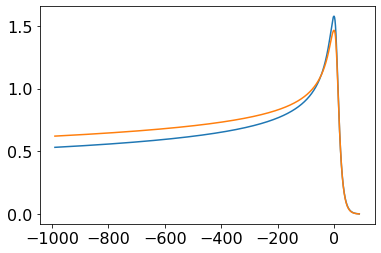

In [30]:
plt.figure()
plt.plot(times0, ts0_amp[0])
plt.plot(times0, ts0_amp[-1])


Step 	 Error
1 	 623.0464123687077
2 	 2.917812717236643
3 	 0.007274941124819634
4 	 0.00011809822137820447
5 	 1.4354532936522446e-05
6 	 4.5437684548232937e-07
7 	 2.9829789127688855e-07
8 	 2.5333861231047194e-08
9 	 1.1449628800619394e-08
10 	 2.6358293325756676e-09
11 	 2.0156676328042522e-09
12 	 5.794618118670769e-10
13 	 4.806679498869926e-10
14 	 3.6993696994613856e-10
15 	 1.3415046851150692e-11
16 	 1.1596057447604835e-11
17 	 3.410605131648481e-12
18 	 1.7053025658242404e-12
19 	 7.958078640513122e-13


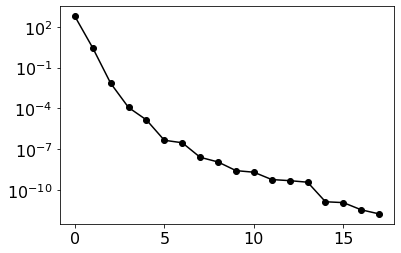

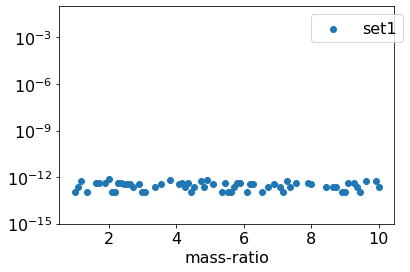

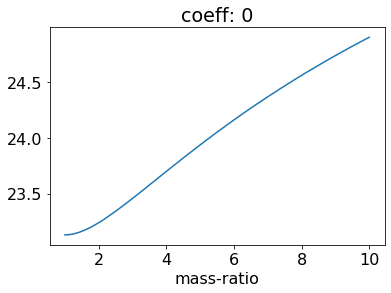

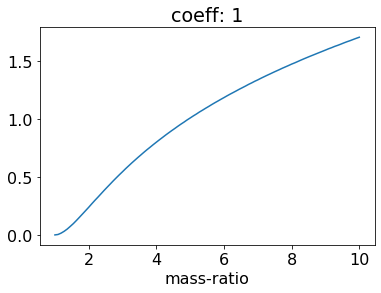

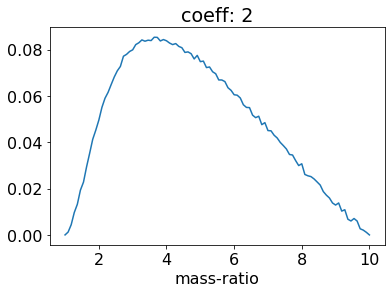

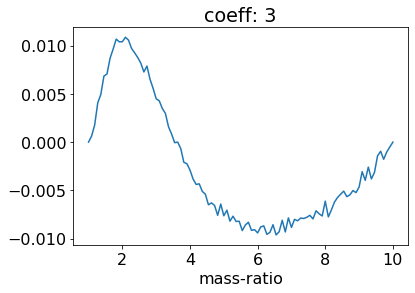

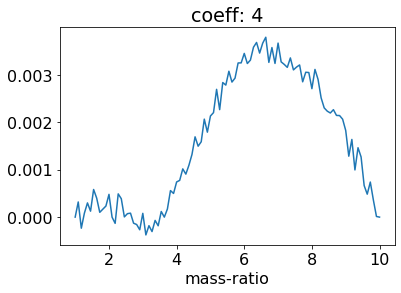

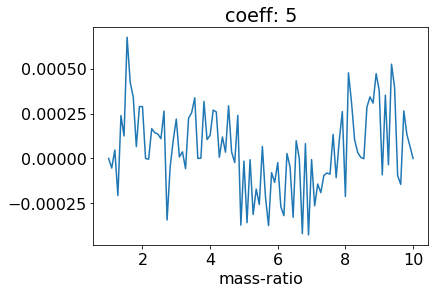

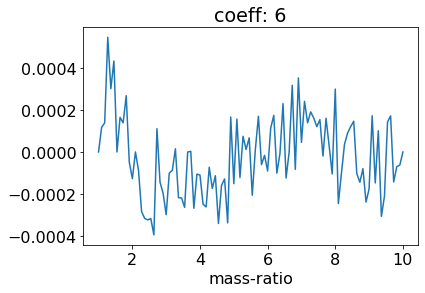

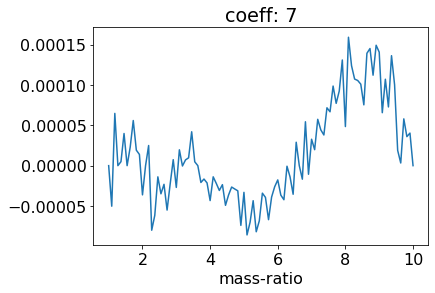

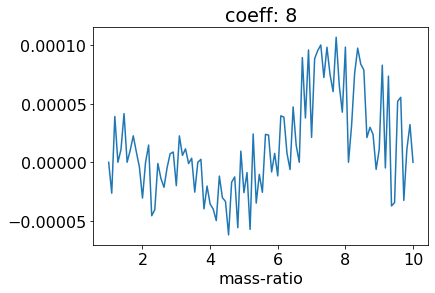

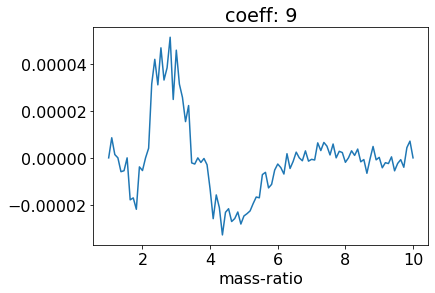

('\nStep', '\t', 'Nodes')
(1, '\t', 610)
(2, '\t', 200)
(3, '\t', 621)
(4, '\t', 567)
(5, '\t', 602)
(6, '\t', 615)
(7, '\t', 594)
(8, '\t', 631)
(9, '\t', 607)
(10, '\t', 470)
(11, '\t', 611)
(12, '\t', 255)
(13, '\t', 608)
(14, '\t', 121)
(15, '\t', 613)
(16, '\t', 0)
(17, '\t', 54)
(18, '\t', 572)


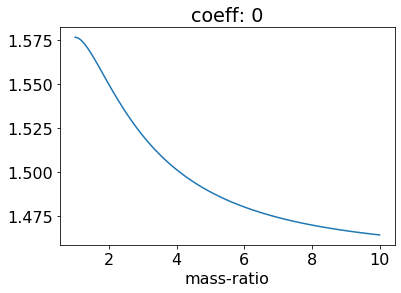

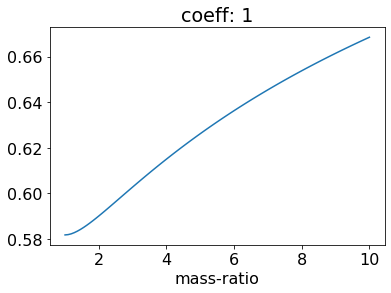

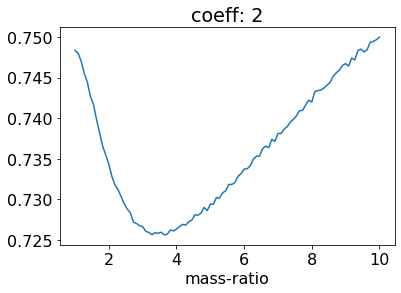

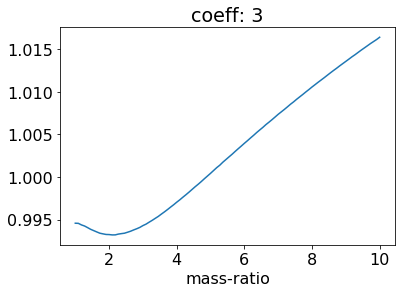

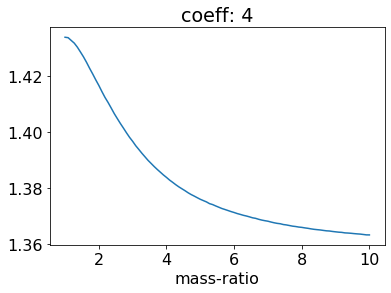

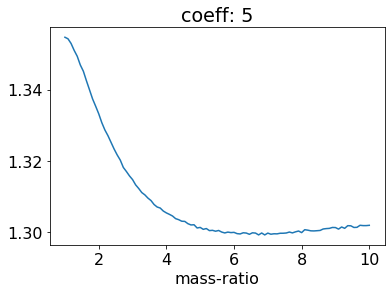

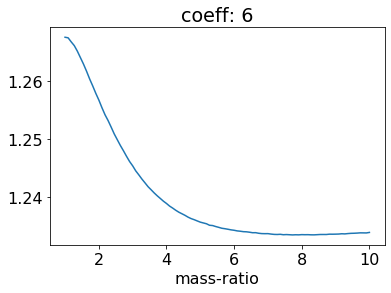

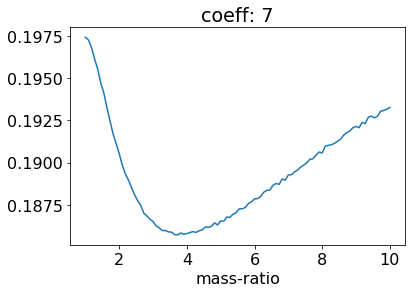

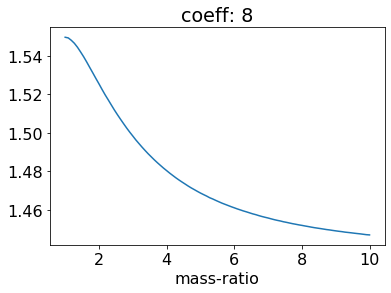

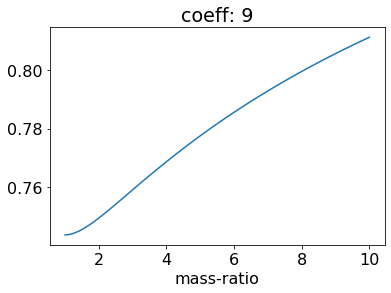

In [31]:
build_rb_and_plot_alpha(times0, ts0_amp, coords0)

# try some other data

## time domain data but no alignment

In [17]:
%%time
# generate training and test sets

times = []
# ts1_hlm = []
ts1_amp = []
ts1_phase = []

M = 60

deltaT=1/4096.
deltaT_M = phenom.StoM(deltaT, M)
f_min = 10
t_min = -1000
t_max = 100

npts=666
new_times = np.linspace(t_min, t_max, npts)
# new_times = np.arange(t_min, t_max, deltaT_M)

qs = np.linspace(1, 10., 100)


for i in range(len(qs)):
    m1, m2 = phenom.m1_m2_M_q(M, qs[i])
    tt, hhlm = lalutils.gen_td_modes_wf(lalutils.gen_td_modes_wf_params(m1=m1, m2=m2, deltaT=deltaT, f_min=f_min))
    
#     amp_pre_fac = phenom.eta_from_q(
#         qs[i]) * lalutils.td_amp_scale(M, 1)
#     hhlm = hhlm / amp_pre_fac
#     aa = aa / ff**(-7/6.)

    # convert to dimensionless units
    tt = phenom.StoM(tt, m1+m2)
    h22 = hhlm[(2,2)]

    mask = (tt >= t_min) & (tt < t_max)
    tt = tt[mask]
    h22 = h22[mask]
    
    amp = np.abs(h22)
    phase = np.unwrap(np.angle(h22))
    
    isampe = lambda x, y : IUS(x, y)(new_times)
    
    amp = isampe(tt, amp)
    phase = isampe(tt, phase)
    
    amp_pre_fac = phenom.eta_from_q(qs[i]) * lalutils.td_amp_scale(M, 1)
    amp = amp / amp_pre_fac
    
    times.append(tt)
#     ts1_hlm.append(h22)
    ts1_amp.append(amp)
    ts1_phase.append(phase)
    
ts1_amp = np.array(ts1_amp)
ts1_phase = np.array(ts1_phase)


CPU times: user 1min 39s, sys: 3.01 s, total: 1min 42s
Wall time: 1min 42s


In [18]:
len(new_times)

666

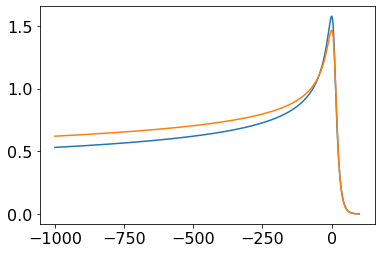

In [19]:
plt.figure()
plt.plot(new_times, ts1_amp[0])
plt.plot(new_times, ts1_amp[-1])

In [20]:
new_times.shape

(666,)

In [21]:
times0.shape

(666,)

In [22]:
ts1_amp.shape

(100, 666)

In [23]:
ts0_amp.shape

(100, 666)

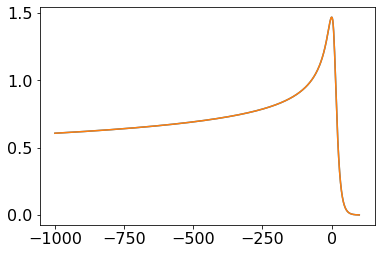

In [24]:
plt.figure()
plt.plot(new_times, ts1_amp[-20])
plt.plot(times0, ts0_amp[-20])


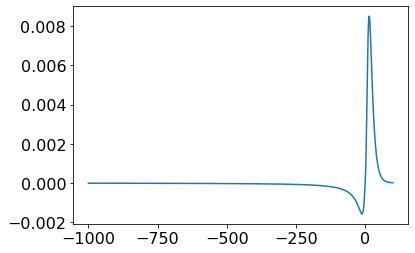

In [25]:
plt.figure()
plt.plot(new_times, ts1_amp[-1]-ts0_amp[-1])
# plt.xlim(-50,50)

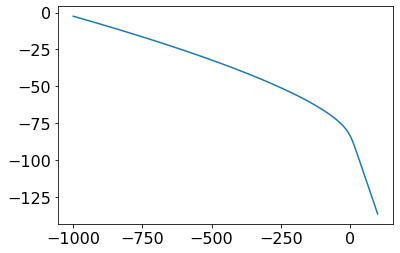

In [26]:
plt.figure()
plt.plot(new_times, ts1_phase[2])


Step 	 Error
1 	 626.9571845368034
2 	 2.9341463995585855
3 	 0.007956033622690484
4 	 0.00012274000039269595
5 	 1.2290792142266582e-05
6 	 1.9787012206506915e-07
7 	 8.158622222254053e-08
8 	 9.025711733556818e-09
9 	 5.448328010970727e-09
10 	 1.6478907127748244e-09
11 	 1.18257048598025e-09
12 	 6.979234967730008e-10
13 	 1.645048541831784e-10
14 	 1.211901690112427e-10
15 	 7.275957614183426e-12
16 	 5.343281372915953e-12
17 	 2.2737367544323206e-12
18 	 1.2505552149377763e-12
19 	 5.684341886080801e-13


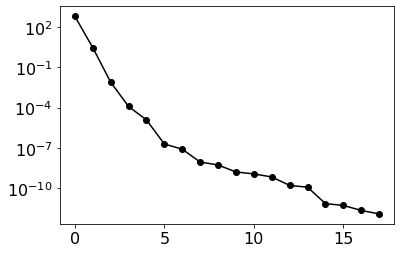

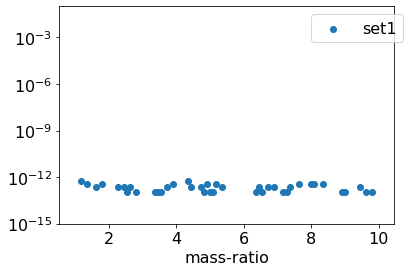

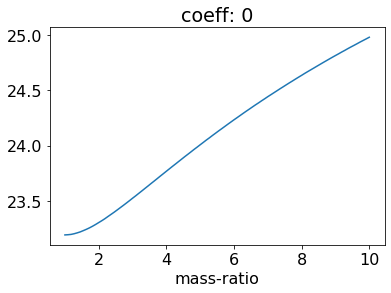

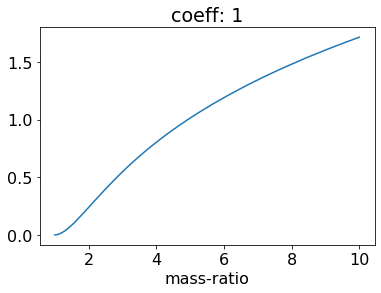

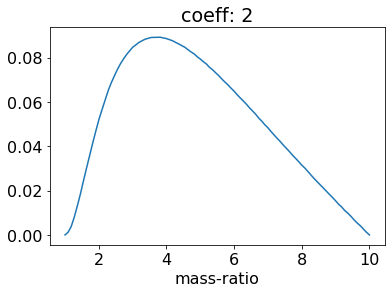

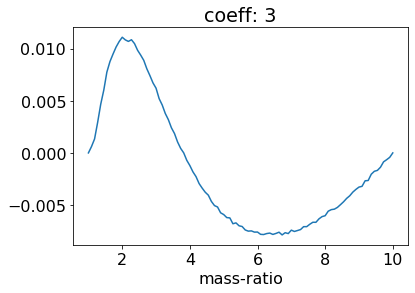

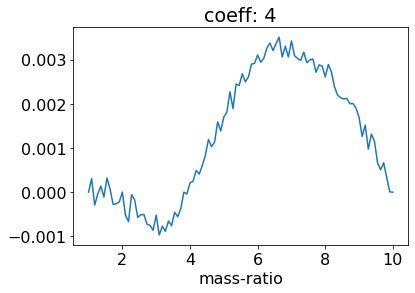

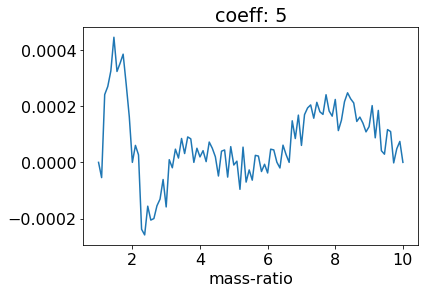

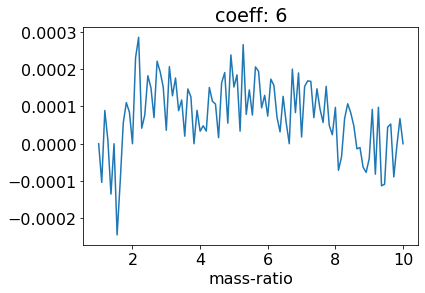

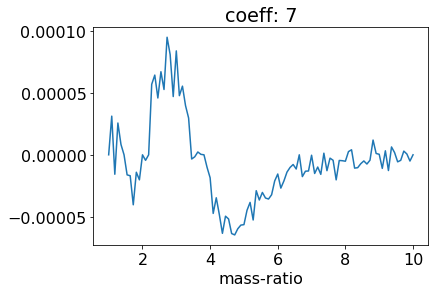

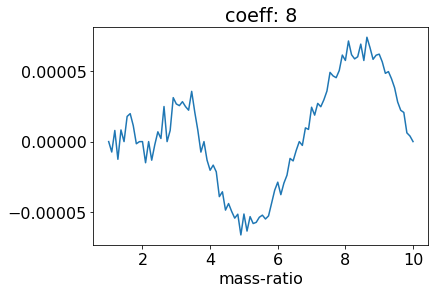

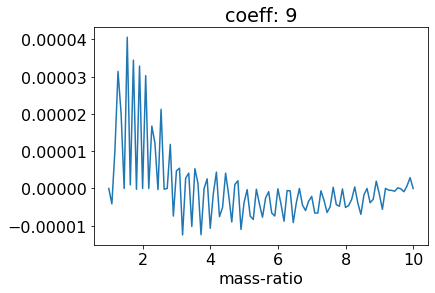

('\nStep', '\t', 'Nodes')
(1, '\t', 605)
(2, '\t', 201)
(3, '\t', 616)
(4, '\t', 563)
(5, '\t', 597)
(6, '\t', 588)
(7, '\t', 603)
(8, '\t', 611)
(9, '\t', 625)
(10, '\t', 601)
(11, '\t', 604)
(12, '\t', 126)
(13, '\t', 606)
(14, '\t', 70)
(15, '\t', 437)
(16, '\t', 5)
(17, '\t', 565)
(18, '\t', 602)


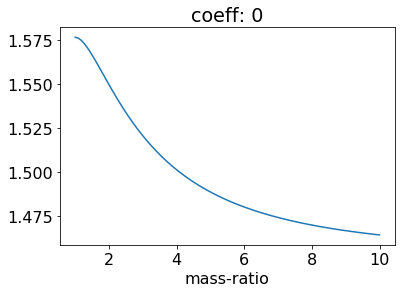

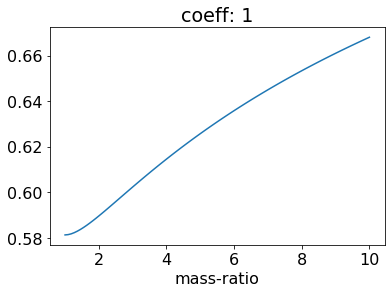

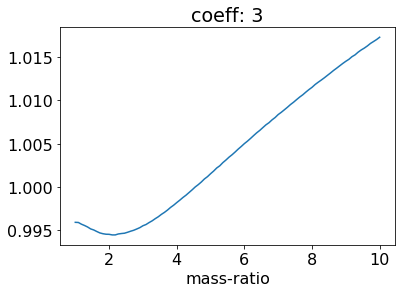

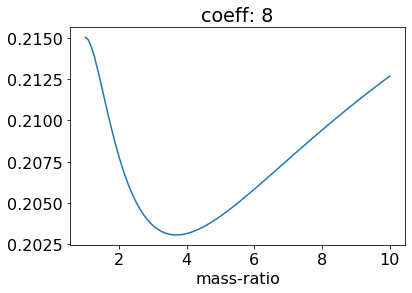

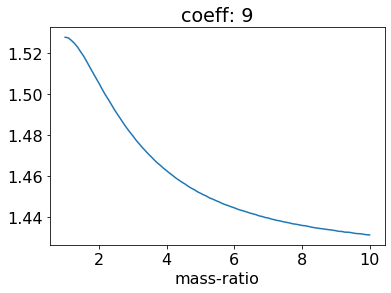

In [27]:
build_rb_and_plot_alpha(new_times, ts1_amp, qs)

## time domain data but with some more care with alignment

## frequency domain

In [28]:
lalutils.gen_fd_wf_params()

{'m1': 50,
 'm2': 50,
 'S1x': 0,
 'S1y': 0,
 'S1z': 0,
 'S2x': 0,
 'S2y': 0,
 'S2z': 0,
 'distance': 1,
 'inclination': 0,
 'phiRef': 0,
 'longAscNodes': 0,
 'eccentricity': 0,
 'meanPerAno': 0,
 'deltaF': 0.0625,
 'f_min': 10,
 'f_max': 200,
 'f_ref': 30,
 'LALpars': None,
 'approximant': 70}

In [29]:
lalutils.gen_fd_wf(lalutils.gen_fd_wf_params())

(array([0.000000e+00, 6.250000e-02, 1.250000e-01, ..., 2.558750e+02,
        2.559375e+02, 2.560000e+02]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.        ,  0.        ,  0.        , ..., 81.68140899,
        81.68140899, 81.68140899]))

In [30]:
%%time
# generate training and test sets

freq = []
ts1_amp = []
ts1_phase = []

M = 60

f_min=40
f_max=350

qs = np.linspace(1, 10., 1000)


for i in range(len(qs)):
    m1, m2 = phenom.m1_m2_M_q(M, qs[i])
    ff, aa, pp = lalutils.gen_fd_wf(lalutils.gen_fd_wf_params(m1=m1, m2=m2, f_max=500), f_min=f_min, f_max=f_max)
    
    
    amp_pre_fac = phenom.eta_from_q(
        qs[i]) * lalutils.fd_amp_scale(M, 1)
    aa = aa / amp_pre_fac
#     aa = aa / ff**(-7/6.)
    
    freq.append(ff)
    ts1_amp.append(aa)
    ts1_phase.append(pp)
    
freq = np.array(freq[0])
ts1_amp = np.array(ts1_amp)
ts1_phase = np.array(ts1_phase)


CPU times: user 1.06 s, sys: 69.3 ms, total: 1.13 s
Wall time: 1.14 s


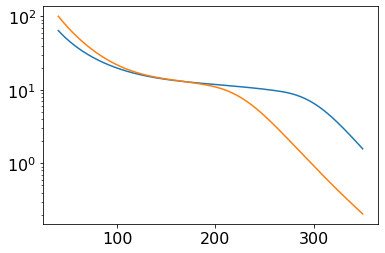

In [31]:
plt.figure()
plt.plot(freq, ts1_amp[0])
plt.plot(freq, ts1_amp[-1])
plt.yscale('log')


Step 	 Error
1 	 179555.44956700996
2 	 10975.771960142069
3 	 283.6277015016094
4 	 9.987397494289326
5 	 2.027294043422444
6 	 0.06825407108408399
7 	 0.008753987232921645
8 	 0.004061804342200048
9 	 0.0010460809280630201
10 	 0.00035576088703237474
11 	 0.00024770213349256665
12 	 0.00013226257578935474
13 	 0.0001078470959328115
14 	 7.229678158182651e-05
15 	 3.6924524465575814e-05
16 	 9.253199095837772e-06
17 	 8.763294317759573e-06
18 	 7.890135748311877e-06
19 	 5.726673407480121e-06
20 	 5.196125130169094e-06
21 	 4.6831846702843904e-06
22 	 2.942455466836691e-06
23 	 2.7051428332924843e-06
24 	 2.6341003831475973e-06
25 	 2.468237653374672e-06
26 	 2.294778823852539e-06
27 	 1.169741153717041e-06
28 	 9.884388418868184e-07
29 	 7.9738674685359e-07
30 	 3.727036528289318e-07
31 	 3.216409822925925e-07
32 	 2.997112460434437e-07
33 	 2.790329745039344e-07
34 	 2.4326436687260866e-07
35 	 2.2299354895949364e-07
36 	 2.0832521840929985e-07
37 	 1.7117417883127928e-07
38 	 1.43

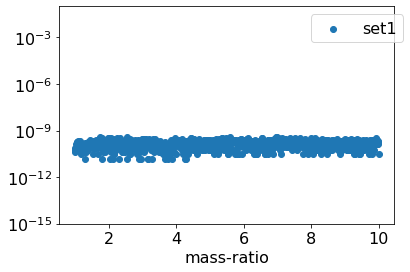

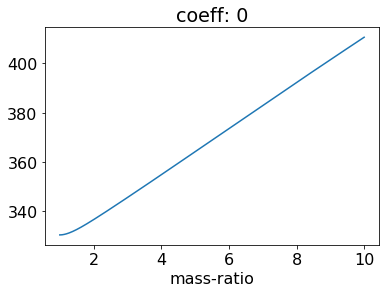

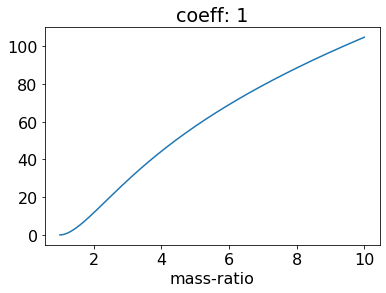

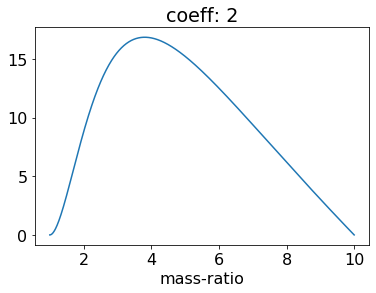

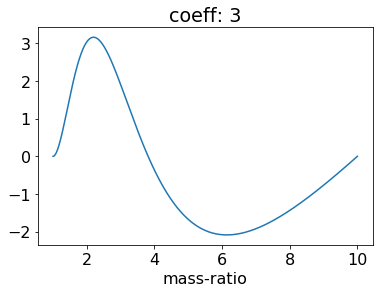

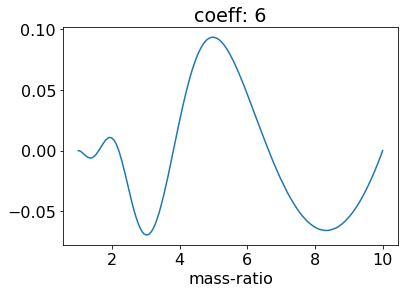

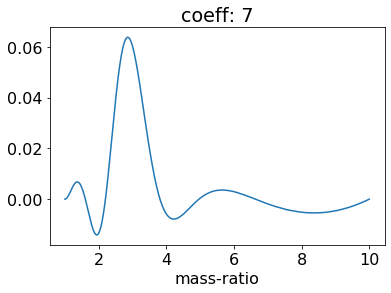

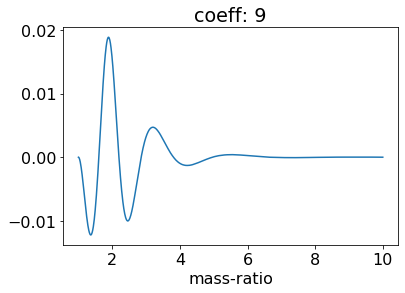

('\nStep', '\t', 'Nodes')
(1, '\t', 0)
(2, '\t', 3656)
(3, '\t', 3074)
(4, '\t', 4253)
(5, '\t', 2725)
(6, '\t', 3380)
(7, '\t', 2865)
(8, '\t', 3209)
(9, '\t', 2550)
(10, '\t', 3310)
(11, '\t', 2959)
(12, '\t', 3496)
(13, '\t', 3141)
(14, '\t', 2792)
(15, '\t', 2641)
(16, '\t', 3344)
(17, '\t', 3021)
(18, '\t', 2588)
(19, '\t', 2923)
(20, '\t', 3438)
(21, '\t', 3251)
(22, '\t', 3112)
(23, '\t', 2838)
(24, '\t', 3524)
(25, '\t', 2488)
(26, '\t', 2690)
(27, '\t', 2766)
(28, '\t', 3551)
(29, '\t', 2619)
(30, '\t', 2989)
(31, '\t', 3405)
(32, '\t', 3055)
(33, '\t', 3233)
(34, '\t', 3171)
(35, '\t', 2568)
(36, '\t', 3328)
(37, '\t', 2941)
(38, '\t', 2521)
(39, '\t', 3037)
(40, '\t', 3466)
(41, '\t', 3282)
(42, '\t', 2895)
(43, '\t', 3190)
(44, '\t', 2706)
(45, '\t', 3423)
(46, '\t', 3126)
(47, '\t', 2813)
(48, '\t', 2852)
(49, '\t', 2661)
(50, '\t', 3509)
(51, '\t', 2475)
(52, '\t', 2743)
(53, '\t', 2779)
(54, '\t', 2631)
(55, '\t', 3541)
(56, '\t', 3369)
(57, '\t', 2461)
(58, '\t', 2911)


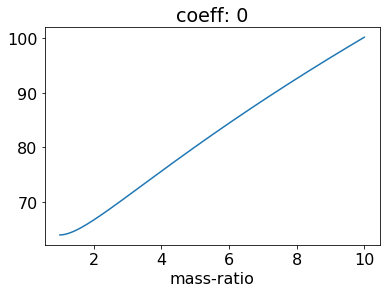

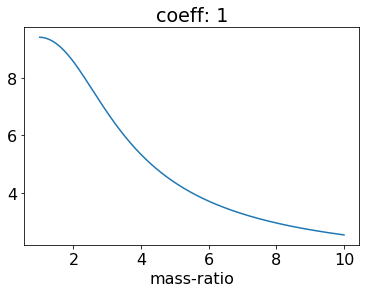

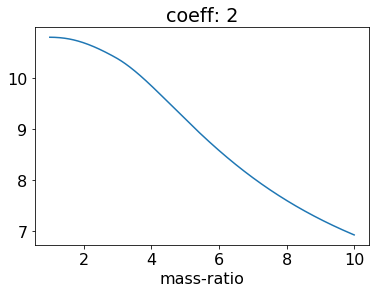

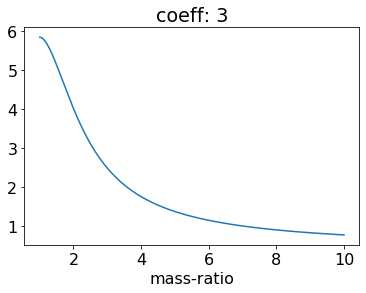

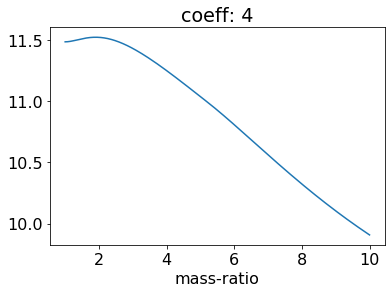

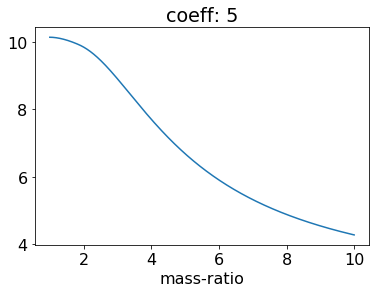

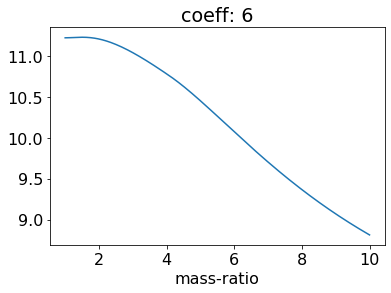

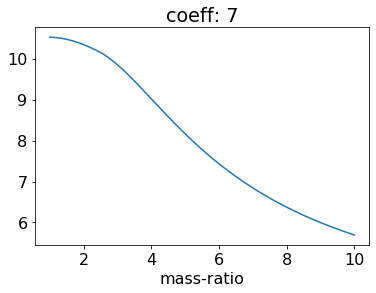

In [32]:
fd_grb = build_rb_and_plot_alpha(freq, ts1_amp, qs)

In [33]:
fd_alphas = np.array([fd_grb.alpha_arr(b, ts1_amp) for b in fd_grb.basis])

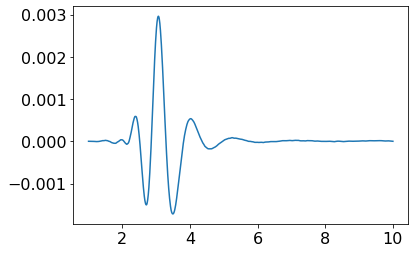

In [34]:
plt.figure()
plt.plot(qs, fd_alphas[16])